# Emotion Recognition

## Creation of the model

In [1]:

from keras import Model
from keras.applications.resnet import ResNet50
from keras.layers import Flatten, Dense
from keras.optimizer_v2.gradient_descent import SGD
from tensorflow import keras

shape = [80, 80]
nbr_classes = 7
train_path = "Databases/FER-2013/train/"
test_path = "Databases/FER-2013/test/"
batch_size = 8
epochs = 50
number_of_last_layers_trainable = 10
learning_rate = 0.001
nesterov = True
momentum = 0.9
preprocess_input = keras.applications.resnet.preprocess_input

model = ResNet50(
    input_shape=shape + [3],
    classes=nbr_classes,
    weights="imagenet",
    include_top=False
)

for layer in model.layers[:number_of_last_layers_trainable]:
    layer.trainable = False

out = model.output

x = Flatten()(out)
x = Dense(nbr_classes, activation="softmax")(x)

model = Model(inputs=model.input, outputs=x)

opti = SGD(
    lr=learning_rate,
    momentum=momentum,
    nesterov=nesterov,
)

model.compile(loss="categorical_crossentropy", optimizer=opti, metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 86, 86, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 40, 40, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 40, 40, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

C:\Users\creif\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Data Augmentation

In [2]:
from glob import glob
from keras_preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    # rescale=1 / 127.5,
    rotation_range=20,
    zoom_range=0.05,
    shear_range=10,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.20,
    preprocessing_function=preprocess_input,
)

# create generators
train_generator = image_gen.flow_from_directory(
    train_path,
    target_size=shape,
    shuffle=True,
    batch_size=batch_size,
)

test_generator = image_gen.flow_from_directory(
    test_path,
    target_size=shape,
    shuffle=True,
    batch_size=batch_size,
)

train_files, test_files = glob(f"{train_path}/*/*.jp*g"), glob(f"{test_path}/*/*.jp*g"),

Found 56930 images belonging to 7 classes.
Found 14226 images belonging to 7 classes.


## Training

Epoch 1/50
3588/3588 [==============================] - 174s 47ms/step - loss: 1.4703 - accuracy: 0.5116 - val_loss: 1.1072 - val_accuracy: 0.5924
Epoch 2/50
3588/3588 [==============================] - 155s 43ms/step - loss: 1.0778 - accuracy: 0.6056 - val_loss: 1.0374 - val_accuracy: 0.6176
Epoch 3/50
3588/3588 [==============================] - 154s 43ms/step - loss: 1.0065 - accuracy: 0.6346 - val_loss: 1.0168 - val_accuracy: 0.6328
Epoch 4/50
3588/3588 [==============================] - 160s 45ms/step - loss: 0.9447 - accuracy: 0.6602 - val_loss: 0.9778 - val_accuracy: 0.6335
Epoch 5/50
3588/3588 [==============================] - 157s 44ms/step - loss: 0.9168 - accuracy: 0.6645 - val_loss: 0.9442 - val_accuracy: 0.6522
Epoch 6/50
3588/3588 [==============================] - 158s 44ms/step - loss: 0.8913 - accuracy: 0.6757 - val_loss: 0.9221 - val_accuracy: 0.6612
Epoch 7/50
3588/3588 [==============================] - 158s 44ms/step - loss: 0.8659 - accuracy: 0.6841 - val_loss: 0

C:\Users\creif\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 0.8796692490577698
Test accuracy: 0.681498646736145


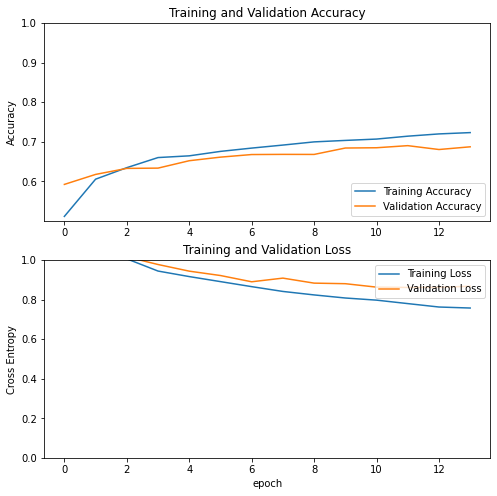

In [3]:
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

early_stop = EarlyStopping(monitor="val_accuracy", patience=2)
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    steps_per_epoch=len(train_files) // batch_size,
    validation_steps=len(test_files) // batch_size,
    callbacks=[early_stop],
)
score = model.evaluate_generator(test_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# curves related to the training

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()


# Testing


INFO:tensorflow:Assets written to: ./trained_models/from_jupyter\assets


C:\Users\creif\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


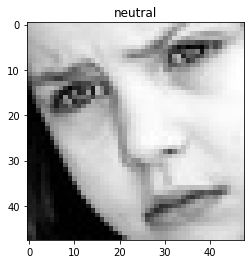

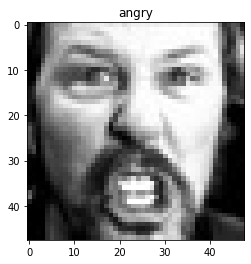

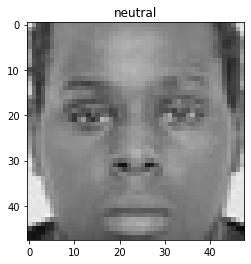

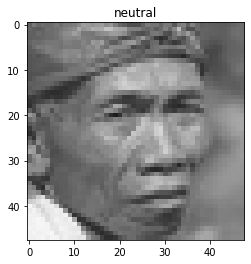

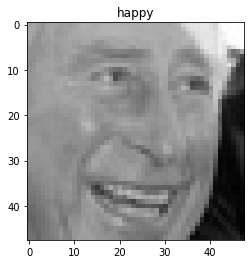

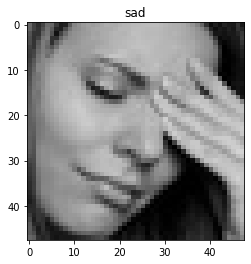

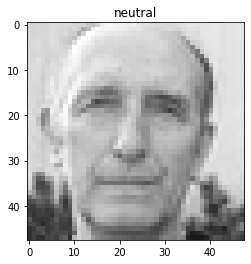

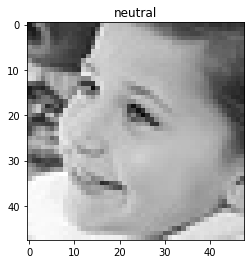

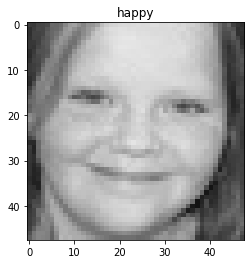

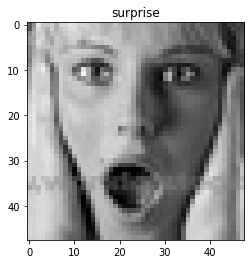

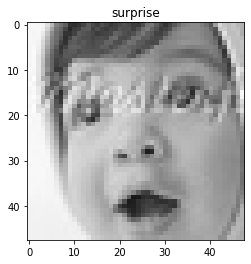

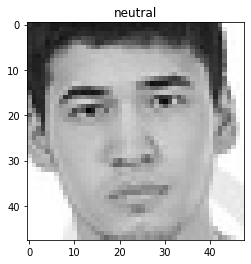

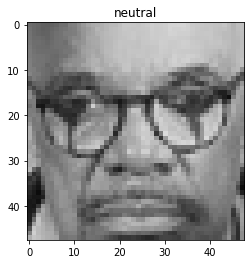

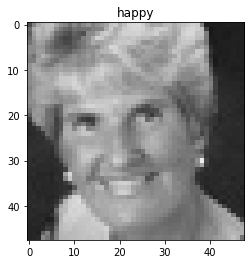

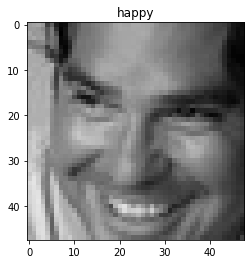

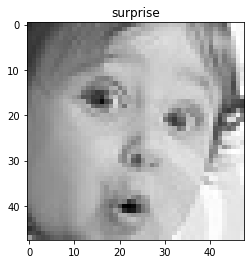

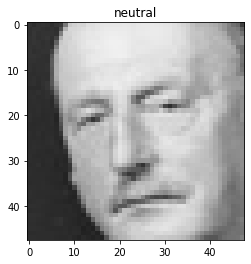

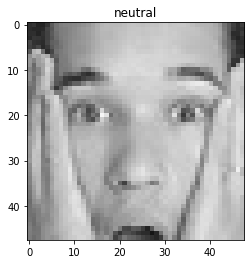

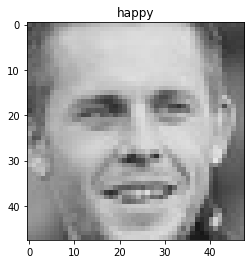

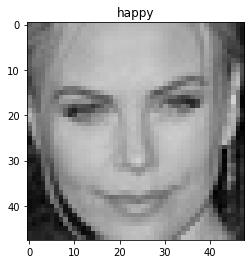

In [9]:
from keras.models import save_model

save_model(model=model, filepath=f"./trained_models/{filename}")
model.save_weights(f"./trained_models/{filename}.h5")

from emotion_recognition.prediction import get_most_probably_emotion
import numpy as np
from numpy import expand_dims
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random as r

for i in range(20):
    img = cv2.imread(test_files[r.randint(0,len(test_files))])
    plt.imshow(img)
    face = Image.fromarray(img).resize(shape)
    face = expand_dims(np.asarray(face), 0)
    plt.title(get_most_probably_emotion(model.predict(face)))
    plt.show()
